In [53]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

import warnings; warnings.simplefilter('ignore')

# Categorizing Videos By Text

In [92]:
dfData = pd.read_csv('../data/cleaned_subset.csv')
dfText = pd.read_csv('../data/image_text.csv')

In [93]:
dfData.head()

,Id,Title,Description,LikeCount,DislikeCount,ViewCount,FavoriteCount,CommentCount,PublishedAt,Channel Id,Channel Title,Tags,Thumbnail Default
0,AUzyaHo0QQc,b'300 pushups a day for 20 days!! - Results!!',b'**NEW** (2016) Abs Workout for 30 Days | htt...,40408,10312,13577683,0,8236,2010-07-22T10:28:30.000Z,UCPE_dNzOtjpP0vUA6papYaw,TheUncutAngel,"['theuncutangel', 'the', 'uncut', 'angel', 'sc...",b'https://i.ytimg.com/vi/AUzyaHo0QQc/default.jpg'
1,1Zgtdb7jp60,b'John Cena - gym',"b""Follow John Cena on twitter: http://www.twit...",37867,1486,9986096,0,2563,2012-02-20T13:55:03.000Z,UCpAxDQTpPNgc6kFiBRNO_1A,JohnCenafan0423,"['John Cena', 'john', 'cena', 'catch', 'raw', ...",b'https://i.ytimg.com/vi/1Zgtdb7jp60/default.jpg'
2,1Sfii7rnkJQ,b'Bodybuilding Motivation - No Time To Waste',"b""Follow me:\nhttp://instagram.com/shaqx.bb\nh...",17688,1291,8532402,0,1515,2012-01-18T15:06:01.000Z,UC3uDucFPe-E0I6CfxtHWZ6w,ShaQxTV,"['ShaQx', 'Bodybuilding', 'Motivation', 'Chall...",b'https://i.ytimg.com/vi/1Sfii7rnkJQ/default.jpg'
3,UUwSKJjx9Go,b'Most Powerful Home Chest Workout Ever : Buil...,b'http://www.6weeksixpack.com This is one of t...,46293,2589,8301027,0,1490,2013-10-17T21:56:53.000Z,UCsiNPbLbwZk43FOCRrdKBlA,Sixpackfactory.com,"['chest workout', 'best chest workout', 'home ...",b'https://i.ytimg.com/vi/UUwSKJjx9Go/default.jpg'
4,Yl3NGvna2KA,b'Greg Plitt Best of The Best Workout Video Pr...,b'SIGN UP TODAY - http://bit.ly/jointheranks\r...,24784,1134,7141821,0,575,2011-03-30T18:57:57.000Z,UCU6WaCIOCL_eToBcsBYFwAQ,Greg Plitt,"['greg plitt', 'workout', 'get huge', 'muscle'...",b'https://i.ytimg.com/vi/Yl3NGvna2KA/default.jpg'


# Feature Creation using Title and Description Text

## Looking at Categorical Workouts

In [94]:
# Conver to lower case 
dfData['Title'] = dfData['Title'].str.lower()


# Abs Workout
dfData['Abs Video'] = (dfData['Title'].str.contains('abs')  | 
                       dfData['Title'].str.contains('six') | 
                       dfData['Title'].str.contains(' 6') | 
                       dfData['Title'].str.contains('abdomen') |
                       dfData['Tags'].str.contains('abs')  | 
                       dfData['Tags'].str.contains('six') | 
                       dfData['Tags'].str.contains(' 6') | 
                       dfData['Tags'].str.contains('abdomen') 
                      )
        
# Chest Workout
dfData['Chest Video'] = (dfData['Title'].str.contains('chest')  |
                         dfData['Title'].str.contains('pushup') | 
                         dfData['Title'].str.contains('bench') | 
                         dfData['Title'].str.contains('bench') | 
                         dfData['Title'].str.contains('push up') |
                         dfData['Title'].str.contains('dumbell press') |
                         dfData['Tags'].str.contains('chest')  |
                         dfData['Tags'].str.contains('pushup') | 
                         dfData['Tags'].str.contains('bench') | 
                         dfData['Tags'].str.contains('bench') | 
                         dfData['Tags'].str.contains('push up') |
                         dfData['Tags'].str.contains('dumbell press'))

# Back Workouts 
dfData['Back Video'] = (dfData['Title'].str.contains('back') | 
                        dfData['Title'].str.contains('pull up') | 
                        dfData['Title'].str.contains('chin up')  | 
                        dfData['Title'].str.contains('deadlift') | 
                        dfData['Tags'].str.contains('back') | 
                        dfData['Tags'].str.contains('pull up') | 
                        dfData['Tags'].str.contains('chin up')  | 
                        dfData['Tags'].str.contains('deadlift'))

# Leg Workouts
dfData['Legs Video'] = (dfData['Title'].str.contains('leg') | 
                        dfData['Title'].str.contains('squat') | 
                        dfData['Title'].str.contains('butt') | 
                        dfData['Title'].str.contains('quad') | 
                        dfData['Title'].str.contains('calve') |
                       dfData['Tags'].str.contains('leg') | 
                        dfData['Tags'].str.contains('squat') | 
                        dfData['Tags'].str.contains('butt') | 
                        dfData['Tags'].str.contains('quad') | 
                        dfData['Tags'].str.contains('calve') )

# Arm Workout
dfData['Arm Video'] = (dfData['Title'].str.contains('shoulder') | 
                       dfData['Title'].str.contains('arm') | 
                       dfData['Title'].str.contains('bicep')  |
                       dfData['Title'].str.contains('tricep') | 
                       dfData['Title'].str.contains('delt') |
                       dfData['Tags'].str.contains('shoulder') | 
                       dfData['Tags'].str.contains('arm') | 
                       dfData['Tags'].str.contains('bicep')  |
                       dfData['Tags'].str.contains('tricep') | 
                       dfData['Tags'].str.contains('delt'))



In [97]:
dfData.loc[dfData['Abs Video'] == True , 'Category'] = 'Abs'
dfData.loc[dfData['Chest Video'] == True , 'Category'] = 'Chest'
dfData.loc[dfData['Back Video'] == True, 'Category'] = 'Back'
dfData.loc[dfData['Legs Video'] == True, 'Category'] = 'Legs'
dfData.loc[dfData['Arm Video'] == True, 'Category'] = 'Arms'

In [98]:
#dfData = dfData.drop(['Abs Video', 'Chest Video','Back Video','Legs Video', 'Arm Video'], axis =1 )
dfData[dfData['Category'].isnull()].shape[0]

6699

In [105]:
absVid = dfData[dfData['Category'] == 'Abs']
chestVid = dfData[dfData['Category'] == 'Chest']
backVid = dfData[dfData['Category'] == 'Back']
legsVid = dfData[dfData['Category'] == 'Legs']
armsVid = dfData[dfData['Category'] == 'Arms']
motivationVid = dfData[dfData['Category'] == 'Motivation']

print "Number of Abs Related Videos: " + str(absVid.shape[0])
print "Number of Chest Related Videos: " + str(chestVid.shape[0])
print "Number of Back Related Videos: " + str(backVid.shape[0])
print "Number of Leg Related Videos: " + str(legsVid.shape[0])
print "Number of Arm Related Videos: " + str(armsVid.shape[0])

Number of Abs Related Videos: 577
Number of Chest Related Videos: 421
Number of Back Related Videos: 551
Number of Leg Related Videos: 1137
Number of Arm Related Videos: 1297


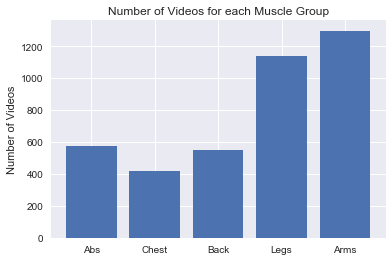

In [100]:
yCols = ['Abs', 'Chest', 'Back', 'Legs', 'Arms']
xCols = [absVid.shape[0], chestVid.shape[0], backVid.shape[0], legsVid.shape[0], armsVid.shape[0]]
y = np.arange(len(yCols))
plt.bar(y, xCols,align = 'center')
plt.xticks(y,yCols)
plt.ylabel("Number of Videos")
plt.title("Number of Videos for each Muscle Group")

## Observation
Legs/Abs/Arms being the most since they target both a guy/girl audience

## Understanding View Distribution

Category
Chest    97198.078385
Abs      94679.384749
Back     79985.274047
Arms     70945.808019
Legs     51488.799472
Name: ViewCount, dtype: float64


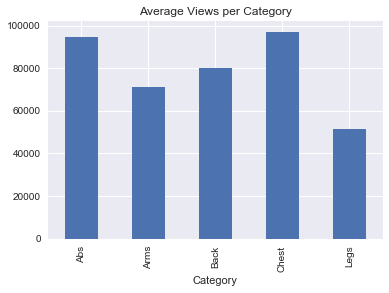

In [101]:
dfData.groupby('Category').ViewCount.mean().plot(kind="bar")
print(dfData.groupby('Category').ViewCount.mean().sort_values(ascending = False))
plt.title("Average Views per Category")
plt.show()

Category
Abs      717.126516
Arms     576.335389
Chest    535.152019
Back     530.119782
Legs     454.141601
Name: LikeCount, dtype: float64


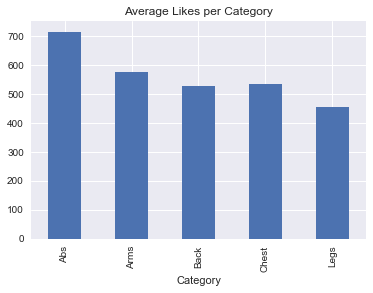

In [102]:
dfData.groupby('Category').LikeCount.mean().plot(kind="bar")
print(dfData.groupby('Category').LikeCount.mean().sort_values(ascending = False))
plt.title("Average Likes per Category")
plt.show()

Category
Abs      88.393414
Chest    86.565321
Back     79.931034
Arms     64.855821
Legs     61.796834
Name: CommentCount, dtype: float64


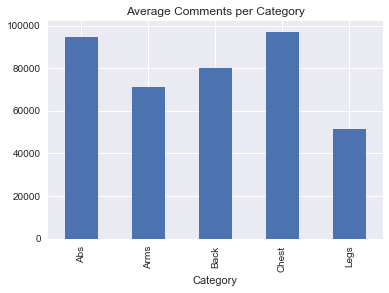

In [103]:
dfData.groupby('Category').ViewCount.mean().plot(kind="bar")
print(dfData.groupby('Category').CommentCount.mean().sort_values(ascending = False))
plt.title("Average Comments per Category")
plt.show()

## Observation

Chest Vidoes are the most popular

In [104]:
# Motivation
# Transformation
# Keywords: Ripped/Extreme/sexy/fat/intense
# BodyBuilding
# Tutorial/How To